In [1]:
import pandas as pd
import datetime
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mstats
import random

In [2]:
df = pd.read_csv('../data/train.csv')

 | __variable__   | __Description__ |
 | :--            | -:-             |
 | ` current_asst_liability_ratio `  | current asset/ (total asset - total equity) 
 | ` current_ratio_st `| Current Ratio = current asset / current liabilities (short term debt + accounts payable)
 | ` intangible_asst_ratio `      | intangible asset / total asset bad
 | ` current_asst_ratio `       | current asset / total asset good
 | ` cash_liability_ratio `     | cash ratio = cash / current liabilities
 | ` capital_employed `     | Capital employed=Total assets−Current liabilities
 | ` capital_turnover_ratio `       | (Capital Turnover Ratio Formula = Operating Revenue - COGS (Cost of Goods Sold) / Capital Employed
 |`ROCE`    |ROCE=EBIT/ Capital employed
 | ` logit_total_asset `      | log(total asset) (a measure of company scale)
 | ` debt_service_ratio `        | Debt service coverage ratio = ebitda/current debt
 | ` interest_coverage_ratio `       | interest coverage ratio = ebitda/interest_expenses
 | ` leverage  ` | leverage = total liabilities/ total Equity
 | ` extraord_ratio `        | extraord_ratio=inc_extraord / rev_operations
 | ` finance_rev_ratio `        | finance_rev_ratio=Financial income / rev_operations
 | ` roa `   | roa = net_profit / total asset 
 | ` roe `    | roe = net_profit / equity
 | ` equity_asst_ratio `  |equity_asst_ratio= equity/total assets
 | ` cash_asst_ratio ` | cash_asst_ratio =cash flow/total asset

### Helping function

In [3]:
# split_dataset
def random_split(df, train_proportion):
    id_lst = df['id'].unique().tolist()
    random.shuffle(id_lst)
    train_id = id_lst[:int(len(id_lst)*train_proportion)]
    test_id = id_lst[int(len(id_lst)*train_proportion):]
    return df[df['id'].isin(train_id)], df[df['id'].isin(test_id)]

# Normalization/ Binorization / Standardization
def winsorize_feature(feature, limit=[0.02, 0.02]):
    return mstats.winsorize(feature, limit)

# visuallization function
def plot_distribution(df, col,num=20):
    df['binned_'+col] = pd.qcut(df[col], num,duplicates='drop')
    df[['binned_'+col, 'defaulted']].groupby('binned_'+col).mean().reset_index().sort_values('binned_'+col).set_index('binned_'+col).plot.bar()

### Target: if the (def_date- stmt_date)<= 12 months, we take it as 1, otherwise 0.

In [4]:
# create default variable
def defaulted(ser):
    if pd.isnull(ser['def_date']) or (ser['def_date'] - ser['stmt_date']).days > 365:
        return 0 
    else:
        return 1

df['stmt_date'] = pd.to_datetime(df['stmt_date'])
df['def_date'] = pd.to_datetime(df['def_date'])
df['defaulted'] = df.apply(defaulted,axis=1)

### feature engineer

### Qiwen Zhang

In [5]:
df['current_asst_liability_ratio'] = df['asst_current']/(df['asst_tot']-df['eqty_tot'])

In [6]:
df['current_ratio_st'] = df['asst_current']/(df['debt_bank_st'] + df['debt_fin_st'] + df['AP_st'] + df['debt_st'])

In [7]:
df['intangible_asst_ratio'] = df['asst_intang_fixed']/df['asst_tot']

In [8]:
df['current_asst_ratio'] = df['asst_current']/df['asst_tot']

In [9]:
df['cash_ratio'] = df['cf_operations']/(df['debt_bank_st'] + df['debt_fin_st'] + df['AP_st'] + df['debt_st'])

In [10]:
df[df['cash_ratio'] == float('-inf')][['cash_ratio','cf_operations','debt_bank_st','debt_fin_st','AP_st','debt_st']]

,cash_ratio,cf_operations,debt_bank_st,debt_fin_st,AP_st,debt_st
2373,-inf,-24547.0,0.0,0.0,0.0,0.0
8125,-inf,-512074.0,0.0,0.0,0.0,0.0
14359,-inf,-10148.0,0.0,0.0,0.0,0.0
14360,-inf,-6725.0,0.0,0.0,0.0,0.0
16138,-inf,-34044.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
1021170,-inf,-2728.0,0.0,0.0,0.0,0.0
1022128,-inf,-227644.0,0.0,0.0,0.0,0.0
1022344,-inf,-3888.0,0.0,0.0,0.0,0.0
1023148,-inf,-510.0,0.0,0.0,0.0,0.0


### Shiqi Yang

##### 7. capital_employed : The total amount of capital used for the acquisition of profits by a firm or project. Capital employed=Total assets−Current liabilities 

##### Capital employed can give a snapshot of how a company is investing its money. From the given trainset, we already have capital_employed and suppose Current liabilities=debt_bank_st+debt_fin_st+ AP_st +debt_st (Short term financial obligation)

In [11]:
df['capital_employed'] = df['asst_tot'] - (df['debt_bank_st'] + df['debt_fin_st'] + df['AP_st'] + df['debt_st'])

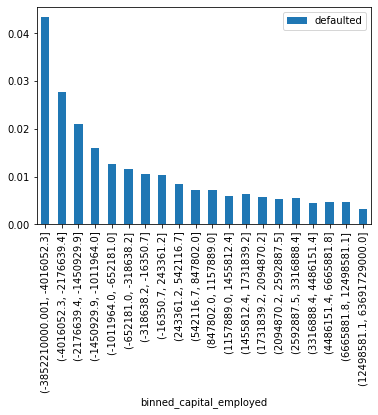

In [12]:
plot_distribution(df,'capital_employed')

#### it seems company with  higher capital employed has less probability to default. This is because higher capital employed means the company has rich funds and active business.

##### 8. capital turnover ratio:indicates the efficiency of the organization with which the capital employed is being utilized.  capital turnover ratio=net sales/ capital_employed

In [13]:
df['capital_turnover_ratio'] = (df['rev_operating']-df['COGS'])/df['capital_employed']

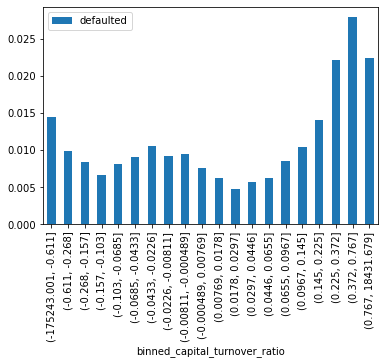

In [14]:
plot_distribution(df,'capital_turnover_ratio')

##### 9.ROCE is a metric for analyzing profitability and for comparing profitability levels across companies in terms of capital. ROCE=EBIT/ Capital employed

##### Here we use the ebitda(Earnings before interest, taxes, depreciation, and amortization) which is also simiar to EBIT(earning before interest and tax)

In [15]:
df['ROCE'] = df['ebitda']/df['capital_employed']

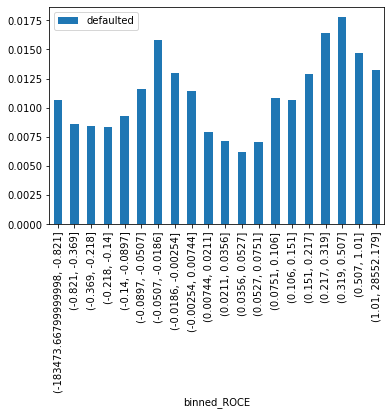

In [16]:
plot_distribution(df,'ROCE')

##### 10. log(total asset) : The size of campany 

In [17]:
df['log_total_asset']=np.log(df['asst_tot'])

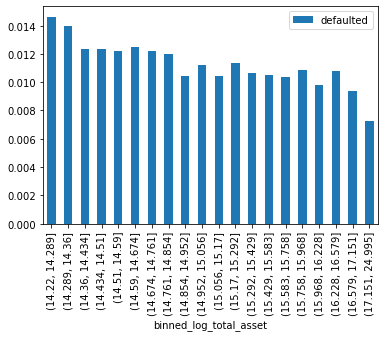

In [18]:
plot_distribution(df,'log_total_asset')

##### We can see for big company(with large asset) they have higher ability to resist risk and therefore lower possibility to default.

##### 11.The debt service coverage ratio(DSCR) is one of the important solvency ratios and helps the analyst determine if the firm generates sufficient net operating income to service its debt repayment. The ratio states net operating income as a multiple of debt obligations due within one year.

##### debt_coverage_ratio= ebit/current debt.  Here we have current debt=debt_st

In [19]:
df['debt_coverage_ratio'] = (df['ebitda'])/(df['debt_st'])

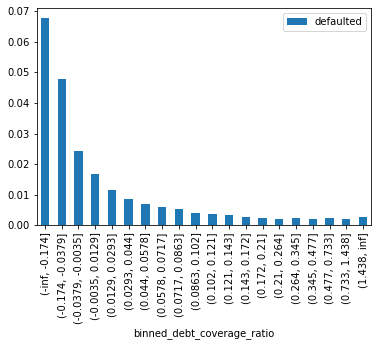

In [20]:
plot_distribution(df,'debt_coverage_ratio')

##### We can see companies with low debt_coverage_ratio has more probability to default

Evaluating DSCR Outcomes

Lenders will routinely assess a borrower's DSCR before making a loan. A DSCR of less than 1 means negative cash flow, which means that the borrower will be unable to cover or pay current debt obligations without drawing on outside sources—in essence, borrowing more.

A DSCR of at least 2 is considered very strong. Many lenders will set minimum DSCR requirements between 1.2 and 1.25.

##### 12.Leverage: total liabilities/total equity

In [21]:
df['leverage'] = (df['asst_tot'] - df['eqty_tot']) / df['eqty_tot']

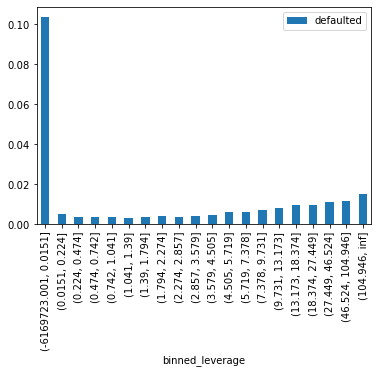

In [22]:
plot_distribution(df,'leverage')

* Negative leverage is a scenario where the addition of debt in a commercial real estate transaction causes the levered return to be less than the unleveraged return.
* Negative leverage occurs when the borrowing costs are greater than the overall return produced by the property’s cash flow.
* The risks of using negative leverage include lower overall returns as well as more serious consequences if the property’s cash flow cannot keep up with the required mortgage payments.

##### 13.The interest coverage ratio measures a company's ability to handle its outstanding debt. It is one of a number of debt ratios that can be used to evaluate a company's financial condition. interest_coverage_ratio= ebitda/ interest_expense

##### Here we use financial_expense similar to interest_expense

In [23]:
df['interest_coverage_ratio']=df['ebitda']/df['exp_financing']

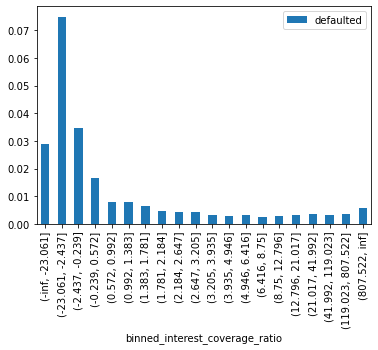

In [24]:
plot_distribution(df,'interest_coverage_ratio')

#### we can see if the interest_coverage_ratio is low(negative), the company has a much higher probabilty to default 

If a company has a low-interest coverage ratio, there's a greater chance the company won't be able to service its debt, putting it at risk of bankruptcy. In other words, a low-interest coverage ratio means there is a low amount of profits available to meet the interest expense on the debt. Also, if the company has variable-rate debt, the interest expense will rise in a rising interest rate environment. 

A high ratio indicates there are enough profits available to service the debt. But it may also mean the company is not using its debt properly. For example, if a company is not borrowing enough, it may not be investing in new products and technologies to stay ahead of the competition in the long term. 

* An interest coverage ratio of at least 2 is generally considered the minimum acceptable amount for a company that has solid, consistent revenues.

* Analysts prefer to see a coverage ratio of 3 or better.
* A coverage ratio below 1  indicates a company cannot meet its current interest payment obligations and, therefore, is not in good financial health.

### Ashely

In [25]:
df['extraord_ratio'] = df['inc_extraord']/ df['rev_operating']
df['finance_rev_ratio'] = df['inc_financing']/df['rev_operating']

In [26]:
df['equity_asst_ratio'] = df['eqty_tot']/df['asst_tot']
df['cash_asst_ratio'] = df['cf_operations']/df['asst_tot']

In [27]:
df.to_csv('../data/with_added_feature.csv')

### Train_test_split

In [28]:
# random test split
def random_split(df, train_proportion):
    id_lst = df['id'].unique().tolist()
    random.shuffle(id_lst)
    train_id = id_lst[:int(len(id_lst)*train_proportion)]
    test_id = id_lst[int(len(id_lst)*train_proportion):]
    return df[df['id'].isin(train_id)], df[df['id'].isin(test_id)]

In [29]:
train, test = random_split(df, 0.7)

In [30]:
train.shape

(716418, 68)

In [31]:
test.shape

(307134, 68)

In [32]:
df.iloc[:,39:].drop(columns = ['wc_net','margin_fin','cf_operations']).isnull().sum()

roa                                   27
roe                                72937
defaulted                              0
current_asst_liability_ratio          12
current_ratio_st                  122834
intangible_asst_ratio                162
current_asst_ratio                     1
cash_ratio                        122927
capital_employed                  122817
binned_capital_employed           122817
capital_turnover_ratio            122934
binned_capital_turnover_ratio     122934
ROCE                              122850
binned_ROCE                       122850
log_total_asset                        0
binned_log_total_asset                 0
debt_coverage_ratio                  163
binned_debt_coverage_ratio           163
leverage                               1
binned_leverage                        1
interest_coverage_ratio              870
binned_interest_coverage_ratio       870
extraord_ratio                     13710
finance_rev_ratio                   2957
equity_asst_rati

### cross_ validation 

In [33]:
test_series = np.array(mstats.winsorize(df['current_asst_liability_ratio'],limits=[0.02,0.02]))
np.quantile(test_series,[1])

array([5.50998557])

In [34]:
df.columns.tolist().index('roa')

39